# Pneumonio detection from X-Ray using CNN Deep Learning

In [1]:
#Importing Libraries

import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

## Sample of the images we are using 

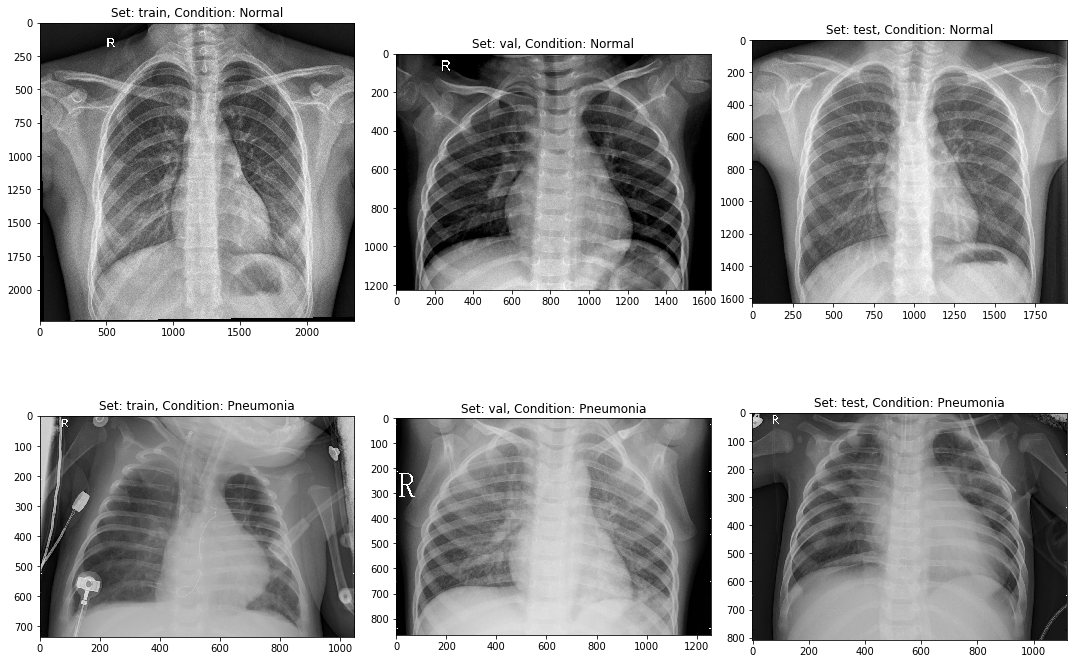

In [6]:
input_path = '/Users/pranavtomar/Downloads/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [7]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [8]:
# Importing libraries used for image generation and modelling

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [11]:
# Processing Data


In [12]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range= 0.2,
                horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(
                input_path+'train',
                target_size = (64, 64),
                batch_size = 32,
                class_mode = 'binary')

test_set = test_datagen.flow_from_directory(
                input_path+'test',
                target_size = (64, 64),
                batch_size = 32,
                class_mode = 'binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (64, 64))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
    test_data.append(img)
    test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    

In [17]:
train_set

In [18]:
test_set

In [19]:
test_data

array([[[[0.54901963, 0.54901963, 0.54901963],
         [0.5411765 , 0.5411765 , 0.5411765 ],
         [0.5529412 , 0.5529412 , 0.5529412 ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.84313726, 0.84313726, 0.84313726],
         [0.9843137 , 0.9843137 , 0.9843137 ]],

        [[0.6862745 , 0.6862745 , 0.6862745 ],
         [0.627451  , 0.627451  , 0.627451  ],
         [0.5686275 , 0.5686275 , 0.5686275 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.99215686, 0.99215686, 0.99215686]],

        [[0.6901961 , 0.6901961 , 0.6901961 ],
         [0.7176471 , 0.7176471 , 0.7176471 ],
         [0.5686275 , 0.5686275 , 0.5686275 ],
         ...,
         [0.6431373 , 0.6431373 , 0.6431373 ],
         [0.7176471 , 0.7176471 , 0.7176471 ],
         [0.94509804, 0.94509804, 0.94509804]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [20]:
test_labels

array([0, 1])

# Adding layers to you NN

In [21]:
# Input Layer
inputs = Input(shape=(64,64, 3))

In [22]:
# Convolution layer 1st block
x = Conv2D(filters=16, kernel_size=( 3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

In [25]:
# Convolution layer 2nd block
x = SeparableConv2D(filters=32, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

In [26]:
# Convolution layer 3rd block
x = SeparableConv2D(filters=64, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

In [27]:
# Convolution layer 4th block
x = SeparableConv2D(filters=128, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

In [28]:
# Convolution layer 5th block
x = SeparableConv2D(filters=256, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

In [29]:
#FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

In [31]:
#Output Layer
output = Dense(units=1, activation='sigmoid')(x)

In [35]:
#Compiling model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [37]:
history = model.fit_generator(
        train_set,
        steps_per_epoch=train_set.samples // 32,
        epochs = 20,
        validation_data=test_set,
        validation_steps=test_set.samples // 32,
        callbacks=[checkpoint, lr_reduce]
        )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
163/163 [==============================] - 76s 465ms/step - loss: 0.3362 - accuracy: 0.8501 - val_loss: 0.6616 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 75s 457ms/step - loss: 0.2154 - accuracy: 0.9197 - val_loss: 0.6592 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 74s 456ms/step - loss: 0.1906 - accuracy: 0.9298 - val_loss: 0.7437 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 74s 454ms/step - loss: 0.1801 - accuracy: 0.9356 - val_loss: 0.5851 - val_accuracy: 0.6349 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9398
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 74s 455ms/step - loss: 0.1709 - accuracy: 0.9398 - val_loss: 0.6353 - val

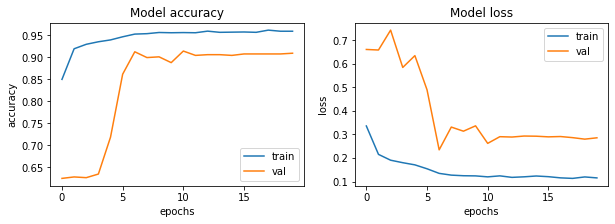

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[0 1]
 [0 1]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall: 100.0%
F1-score: 66.66666666666667

TRAIN METRIC ----------------------
Train acc: 95.95


In [51]:
test_data

array([[[[0.54901963, 0.54901963, 0.54901963],
         [0.5411765 , 0.5411765 , 0.5411765 ],
         [0.5529412 , 0.5529412 , 0.5529412 ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.84313726, 0.84313726, 0.84313726],
         [0.9843137 , 0.9843137 , 0.9843137 ]],

        [[0.6862745 , 0.6862745 , 0.6862745 ],
         [0.627451  , 0.627451  , 0.627451  ],
         [0.5686275 , 0.5686275 , 0.5686275 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.99215686, 0.99215686, 0.99215686]],

        [[0.6901961 , 0.6901961 , 0.6901961 ],
         [0.7176471 , 0.7176471 , 0.7176471 ],
         [0.5686275 , 0.5686275 , 0.5686275 ],
         ...,
         [0.6431373 , 0.6431373 , 0.6431373 ],
         [0.7176471 , 0.7176471 , 0.7176471 ],
         [0.94509804, 0.94509804, 0.94509804]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [50]:
test_labels.shape

(2,)